# Basics: overfitting a MLP on CIFAR10

# CIFAR-10 dataset

In this notebook, we use the CIFAR-10 dataset made of images from 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck. The images are all of the same size with $3\times 32\times 32$ pixels. The first channel is used for the RGB description of the image with the 2 others are the X and Y position of a pixel.

1. What is the machine learning family this problem is about? What is the nature of the input data?

2. Enumerate some methods that could be used for such a task.

3. We separate the dataset into two parts: train and test. Remind what they are used for.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np

# load data
to_tensor =  t.ToTensor()
normalize = t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
flatten =  t.Lambda(lambda x:x.view(-1))

transform_list = t.Compose([to_tensor, normalize, flatten])
train_set = torchvision.datasets.CIFAR10(root='.', train=True, transform=transform_list, download=True)
test_set = torchvision.datasets.CIFAR10(root='.', train=False, transform=transform_list, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


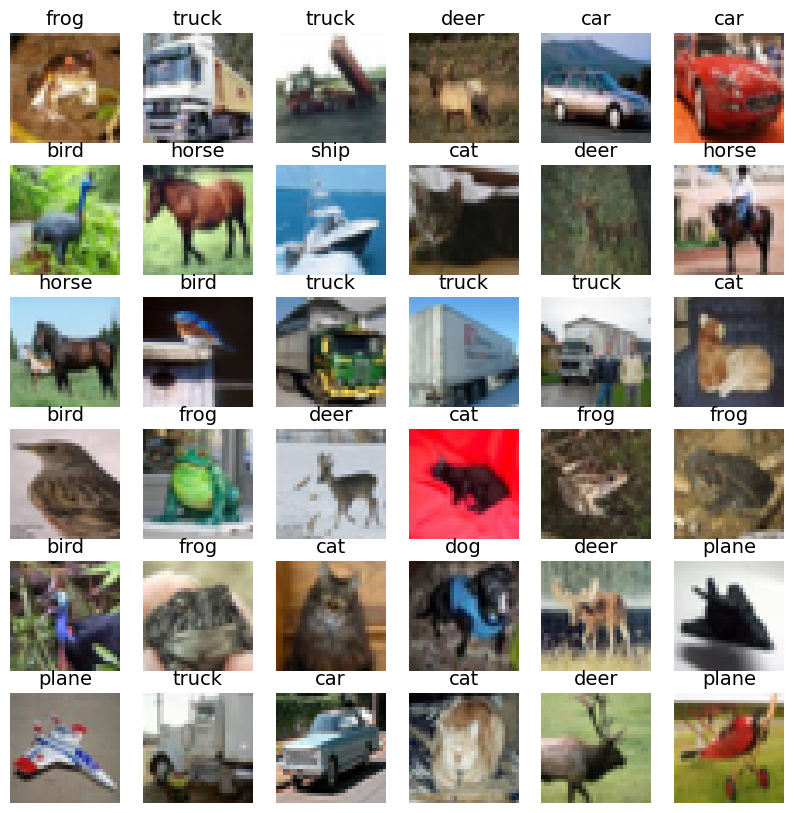

In [ ]:
# Plot some images
nx = 6
ny = 6
fig, ax = plt.subplots(nx, ny, figsize=(10,10))
for i in range(nx):
  for j in range(ny):
    ax[i][j].imshow(train_set.data[i*nx+j])
    ax[i][j].axis('off')
    ax[i][j].set_title(classes[train_set.targets[i*nx+j]],
                       fontsize=14)

In [ ]:
# Your code to check the proportions of images in each class

# Training loop

The basic network is a small neural network made of one layer with 1000 neurons.

4. Draw the diagram of the networks declared in the code below. How many parameters does it have?

The model is specified for you. Now you have to train it on the training data using the backpropagation algorithm and stochastic gradient descent.

5. Remind how SGD works.

6. Specify a loss function and an optimization procedure. In our case, we'll use the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) together with the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html). Set the learning rate to 0.01 and the momentum to 0.9.


In [ ]:
# define network structure
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = # LOSS FUNCTION
optimizer = # OPTIMIZER

# === Train === ###
net.train()

# train loop
for epoch in range(3):
    train_correct = 0
    train_loss = 0
    print('Epoch {}'.format(epoch))

    # loop per epoch
    for i, (batch, targets) in enumerate(train_loader):

        output = net(batch)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        train_correct += pred.eq(targets.view_as(pred)).sum().item()
        train_loss += loss

        if i % 100 == 10: print('Train loss {:.4f}, Train accuracy {:.2f}%'.format(
            train_loss / (i * 64), 100 * train_correct / (i * 64)))

print('End of training.\n')

# === Test === ###
test_correct = 0
net.eval()

# loop, over whole test set
for i, (batch, targets) in enumerate(test_loader):

    output = net(batch)
    pred = output.max(1, keepdim=True)[1]
    test_correct += pred.eq(targets.view_as(pred)).sum().item()

print('End of testing. Test accuracy {:.2f}%'.format(
    100 * test_correct / (len(test_loader) * 64)))

Training loop over CIFAR10 (40,000 train images, 10,000 test images). What happens if you
- switch the training to a GPU? Is it faster?
- Remove the `ReLU()`?
- Increase the learning rate?
- Stack more layers?
- Perform more epochs?

The goal is to completely overfit the training set (i.e. get 100% accuracy?)

This code is highly non-modulable. Create functions for each specific task.
(hint: see [this](https://github.com/pytorch/examples/blob/master/mnist/main.py))

Your training went well. Good. Why not save the weights of the network (`net.state_dict()`) using `torch.save()`?

7. Create a function `train` and `test`.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    print('Epoch {}'.format(epoch))
    train_correct = 0
    train_loss = 0
    train_l = 0
    # loop per epoch
    for i, (batch, targets) in enumerate(train_loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        targets = targets.to(device)

        output = model(batch)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        train_correct += pred.eq(targets.view_as(pred)).sum().item()
        train_loss += loss.item()
        train_l += bs

        if i % 100 == 10: print('Train loss {:.4f}, Train accuracy {:.2f}%'.format(
            train_loss / train_l, 100 * train_correct / train_l))


In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_correct = 0
    test_l =0
    for i, (batch, targets) in enumerate(test_loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        targets = targets.to(device)
        output = model(batch)
        pred = output.max(1, keepdim=True)[1]
        test_correct += pred.eq(targets.view_as(pred)).sum().item()
        test_l += bs

    print('End of testing. Test accuracy {:.2f}%'.format(
    100 * test_correct / test_l))

8. Train a model on the CPU and one on on the GPU. Compare the running times.

In [ ]:
device = 'cpu'
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

In [ ]:
%%time
train(net,device,train_loader,criterion,optimizer,1)

Epoch 1
Train loss 0.0345, Train accuracy 19.32%
Train loss 0.0295, Train accuracy 32.70%
Train loss 0.0282, Train accuracy 36.37%
Train loss 0.0274, Train accuracy 38.16%
Train loss 0.0267, Train accuracy 39.78%
Train loss 0.0263, Train accuracy 40.59%
Train loss 0.0261, Train accuracy 41.20%
Train loss 0.0258, Train accuracy 41.82%
CPU times: user 37.6 s, sys: 144 ms, total: 37.7 s
Wall time: 38.8 s


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

In [ ]:
%%time
train(net,device,train_loader,criterion,optimizer,1)

Epoch 1
Train loss 0.0346, Train accuracy 18.47%
Train loss 0.0295, Train accuracy 32.67%
Train loss 0.0282, Train accuracy 36.43%
Train loss 0.0274, Train accuracy 38.26%
Train loss 0.0267, Train accuracy 39.79%
Train loss 0.0263, Train accuracy 40.52%
Train loss 0.0261, Train accuracy 41.21%
Train loss 0.0258, Train accuracy 41.82%
CPU times: user 35.1 s, sys: 58 ms, total: 35.1 s
Wall time: 36 s


9. Remove the ReLU activation. What becomes the network in this case? Compute and comments the performances.

In [ ]:
# Your code to compare the ReLU and no ReLU networks

10. Change the learning rate. Comment.

In [ ]:
# Your code to compare learning rates

11. Add more layers. Comment.

In [ ]:
# Your code to add more layers to the network

12. Try to make the network completely fit the training set. What can you do for that? Try it!

In [ ]:
# Your code to make the network overfits completely